# Bank Marketing Campaign Analysis
## End-to-End Data Science Workflow

### Student: Fidel Mamani Maquera

**Dataset:** [Bank Marketing Dataset](https://archive.ics.uci.edu/dataset/222/bank+marketing) from UCI Machine Learning Repository

**Business Goal:** Predict whether a client will subscribe to a term deposit based on direct marketing campaigns of a Portuguese banking institution.

This notebook demonstrates a complete data science workflow including:
- Experiment tracking with MLflow
- Exploratory Data Analysis
- Data preprocessing pipelines
- Model building and comparison
- Hyperparameter tuning
- Deep learning baseline with PyTorch


In [ ]:
# Install libraries
%pip install ipykernel notebook numpy pandas matplotlib seaborn scikit-learn xgboost mlflow torch ucimlrepo

  Using cached pandas-2.3.3-cp310-cp310-macosx_11_0_arm64.whl.metadata (91 kB)
  Using cached matplotlib-3.10.7-cp310-cp310-macosx_11_0_arm64.whl.metadata (11 kB)
  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached scikit_learn-1.7.2-cp310-cp310-macosx_12_0_arm64.whl.metadata (11 kB)
  Using cached anyio-4.11.0-py3-none-any.whl.metadata (4.1 kB)
  Using cached jinja2-3.1.6-py3-none-any.whl.metadata (2.9 kB)
  Using cached httpx-0.28.1-py3-none-any.whl.metadata (7.1 kB)
  Using cached tomli-2.3.0-py3-none-any.whl.metadata (10 kB)
  Using cached certifi-2025.11.12-py3-none-any.whl.metadata (2.5 kB)
  Using cached httpcore-1.0.9-py3-none-any.whl.metadata (21 kB)
  Using cached idna-3.11-py3-none-any.whl.metadata (8.4 kB)
  Using cached h11-0.16.0-py3-none-any.whl.metadata (8.3 kB)
  Using cached jsonschema-4.25.1-py3-none-any.whl.metadata (7.6 kB)
  Using cached requests-2.32.5-py3-none-any.whl.metadata (4.9 kB)
  Using cached pytz-2025.2-py2.py3-none-any.whl.m

In [ ]:
# Import libraries
import warnings
warnings.filterwarnings('ignore')

# Data manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Data preprocessing and pipelines
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer

# Machine learning models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# This requires libomp in MACOS, so run the below command if the machine has not
# brew install libomp
import xgboost as xgb
import os
# Evaluation metrics
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report
from sklearn.metrics import confusion_matrix, roc_curve, auc

# MLflow for experiment tracking
import mlflow
import mlflow.sklearn
import mlflow.pytorch

# PyTorch for deep learning
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# UCI ML Repository
from ucimlrepo import fetch_ucirepo

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Configure PyTorch device
if torch.cuda.is_available():
     device = torch.device("cuda")
elif getattr(torch.backends, "mps", None) and torch.backends.mps.is_available():
     device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"✓ Using device: {device} (cuda:{torch.cuda.is_available()}, mps:{getattr(torch.backends, 'mps', None) and torch.backends.mps.is_available()})")
# Plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

print("All libraries imported successfully!")
mlflow.end_run()

✓ Using device: cuda (cuda:True, mps:False)
All libraries imported successfully!


### Setup MLflow Experiment Tracking

It will be used MLflow to track the entire workflow, including EDA metrics, visualizations, preprocessing steps, and model performance.


In [12]:
# Setup MLflow experiment
mlflow.set_experiment("Bank_Marketing_Complete_Workflow")

print("✓ MLflow experiment initialized: Bank_Marketing_Complete_Workflow")
print(f"✓ Tracking URI: {mlflow.get_tracking_uri()}")
print("✓ All EDA, preprocessing, and modeling steps will be tracked")


✓ MLflow experiment initialized: Bank_Marketing_Complete_Workflow
✓ Tracking URI: file:///home/fidel/projects/home-2-data/mlruns
✓ All EDA, preprocessing, and modeling steps will be tracked


## 1. Introduction and Exploratory Data Analysis (EDA)

### 1.1 Load the Dataset and Start MLflow Run


In [13]:
# Start MLflow run for EDA phase
mlflow.start_run(run_name="01_EDA_and_Data_Exploration")

# Load Bank Marketing dataset from UCI ML Repository
bank_marketing = fetch_ucirepo(id=222)

# Extract features and target
X = bank_marketing.data.features
y = bank_marketing.data.targets

# Combine for EDA
df = pd.concat([X, y], axis=1)

# Log dataset metadata
mlflow.log_param("dataset_source", "UCI ML Repository - Bank Marketing")
mlflow.log_param("dataset_id", 222)
mlflow.log_param("total_samples", len(df))
mlflow.log_param("total_features", len(df.columns) - 1)

print(f"Dataset shape: {df.shape}")
print(f"\n✓ Dataset metadata logged to MLflow")
print(f"\nFirst few rows:")
df.head()


Dataset shape: (45211, 17)

✓ Dataset metadata logged to MLflow

First few rows:


,age,job,marital,education,default,balance,housing,loan,contact,day_of_week,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,NaN,5,may,261,1,-1,0,NaN,no
1,44,technician,single,secondary,no,29,yes,no,NaN,5,may,151,1,-1,0,NaN,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,NaN,5,may,76,1,-1,0,NaN,no
3,47,blue-collar,married,NaN,no,1506,yes,no,NaN,5,may,92,1,-1,0,NaN,no
4,33,NaN,single,NaN,no,1,no,no,NaN,5,may,198,1,-1,0,NaN,no


### 1.2 Dataset Overview and Business Goal

**Dataset Description:**
The Bank Marketing dataset contains data from direct marketing campaigns (phone calls) of a Portuguese banking institution. The classification goal is to predict if the client will subscribe to a term deposit (variable y).

**Features include:**
- **Bank client data:** age, job, marital status, education, default status, housing loan, personal loan
- **Campaign data:** contact type, month, day of week, duration, number of contacts
- **Social and economic context:** employment variation rate, consumer price index, consumer confidence index, euribor rate, number of employees

**Business Goal:** Predict whether a client will subscribe (yes/no) to a term deposit to optimize marketing campaign resources and improve conversion rates.


In [14]:
# Dataset information
print("Dataset Information:")
print("="*50)
df.info()

print("\n\nBasic Statistics:")
print("="*50)
df.describe()

print("\n\nMissing Values:")
print("="*50)
missing_values = df.isnull().sum()
print(missing_values)

print("\n\nTarget Variable Distribution:")
print("="*50)
target_dist = df['y'].value_counts()
print(target_dist)
print(f"\nTarget distribution:\n{df['y'].value_counts(normalize=True)}")

# Log EDA metrics to MLflow
mlflow.log_metric("total_missing_values", missing_values.sum())
mlflow.log_metric("num_numerical_features", len(df.select_dtypes(include=[np.number]).columns))
mlflow.log_metric("num_categorical_features", len(df.select_dtypes(include=['object', 'category']).columns))

# Log target distribution
for label, count in target_dist.items():
    mlflow.log_metric(f"target_class_{label}_count", count)

print("\n✓ EDA statistics logged to MLflow")


Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   age          45211 non-null  int64 
 1   job          44923 non-null  object
 2   marital      45211 non-null  object
 3   education    43354 non-null  object
 4   default      45211 non-null  object
 5   balance      45211 non-null  int64 
 6   housing      45211 non-null  object
 7   loan         45211 non-null  object
 8   contact      32191 non-null  object
 9   day_of_week  45211 non-null  int64 
 10  month        45211 non-null  object
 11  duration     45211 non-null  int64 
 12  campaign     45211 non-null  int64 
 13  pdays        45211 non-null  int64 
 14  previous     45211 non-null  int64 
 15  poutcome     8252 non-null   object
 16  y            45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


Basic Statistics:


Missing Values:
ag

### 1.3 Data Visualization (EDA)


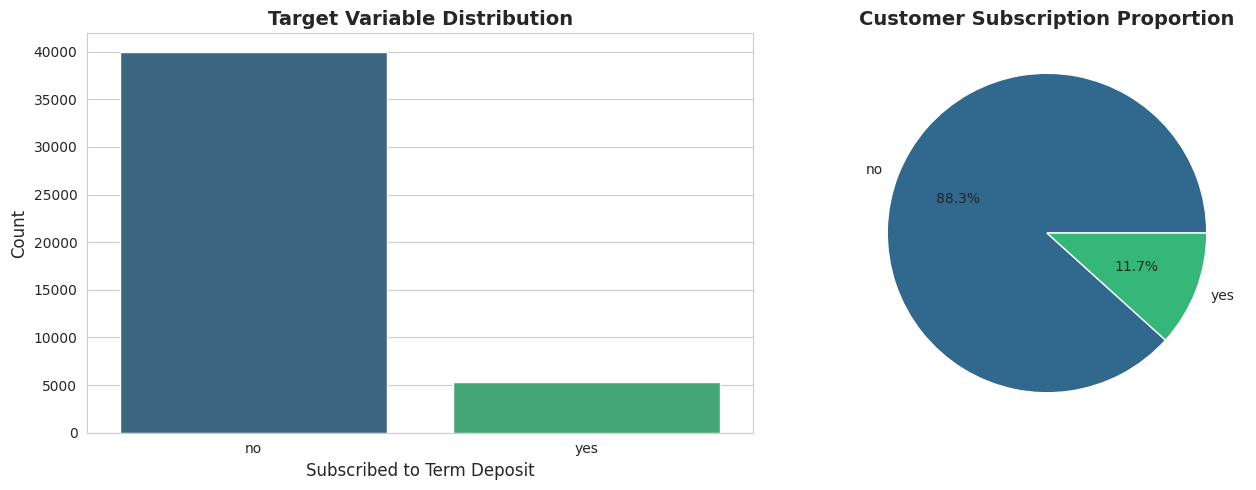

✓ Target distribution plot logged to MLflow


In [ ]:
# Target variable distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Count plot
sns.countplot(data=df, x='y', ax=axes[0], palette='viridis')
axes[0].set_title('Target Variable Distribution', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Subscribed to Term Deposit', fontsize=12)
axes[0].set_ylabel('Count', fontsize=12)

# Pie chart
df['y'].value_counts().plot.pie(autopct='%1.1f%%', ax=axes[1], colors=sns.color_palette('viridis', 2))
axes[1].set_title('Customer Subscription Proportion', fontsize=14, fontweight='bold')
axes[1].set_ylabel('')

plt.tight_layout()

# Log figure to MLflow
mlflow.log_figure(fig, "eda_target_distribution.png")
plt.show()

print("✓ Target distribution plot logged to MLflow")


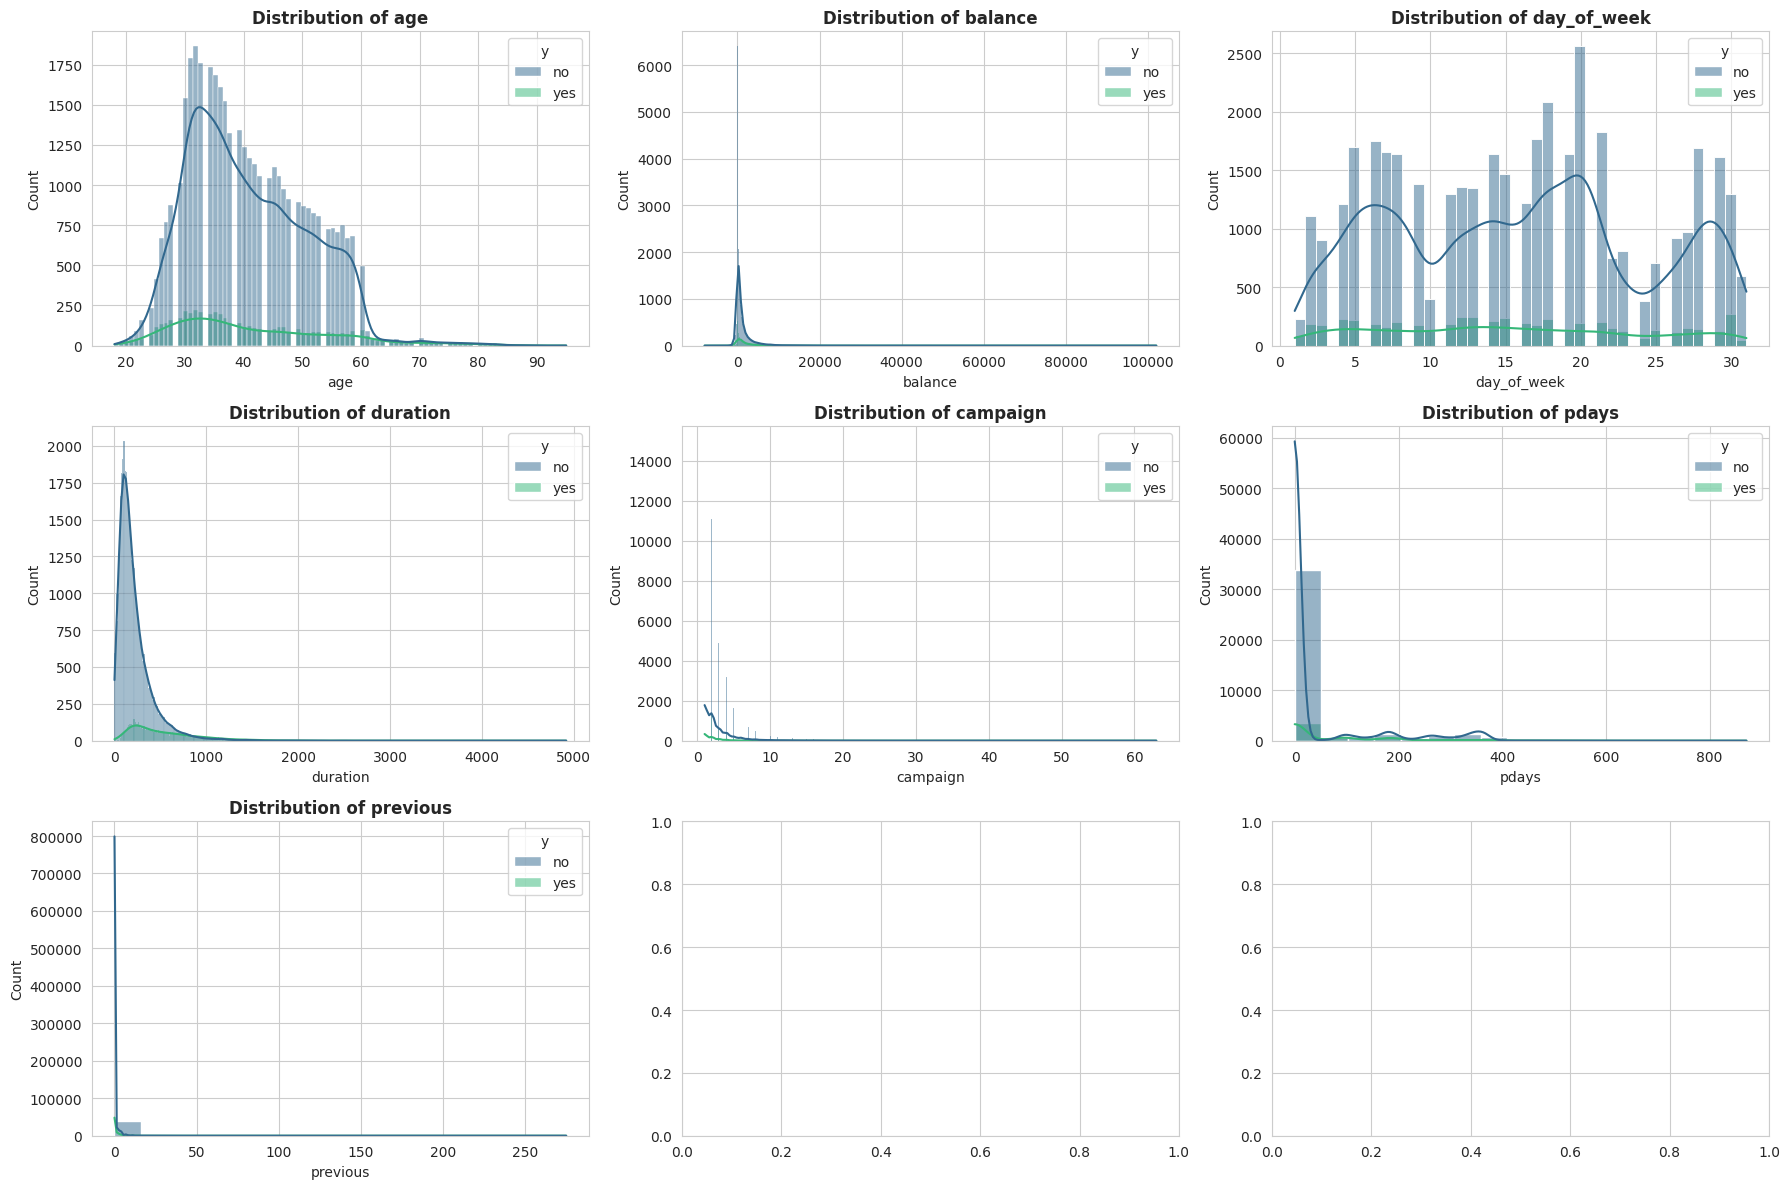

✓ Numerical features distribution logged to MLflow


In [16]:
# Numerical features distribution
numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()
if 'y' in numerical_cols:
    numerical_cols.remove('y')

fig, axes = plt.subplots(3, 3, figsize=(18, 12))
axes = axes.ravel()

for idx, col in enumerate(numerical_cols[:9]):
    sns.histplot(data=df, x=col, hue='y', kde=True, ax=axes[idx], palette='viridis')
    axes[idx].set_title(f'Distribution of {col}', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel(col, fontsize=10)
    
plt.tight_layout()

# Log figure to MLflow
mlflow.log_figure(fig, "eda_numerical_distributions.png")
plt.show()

print("✓ Numerical features distribution logged to MLflow")


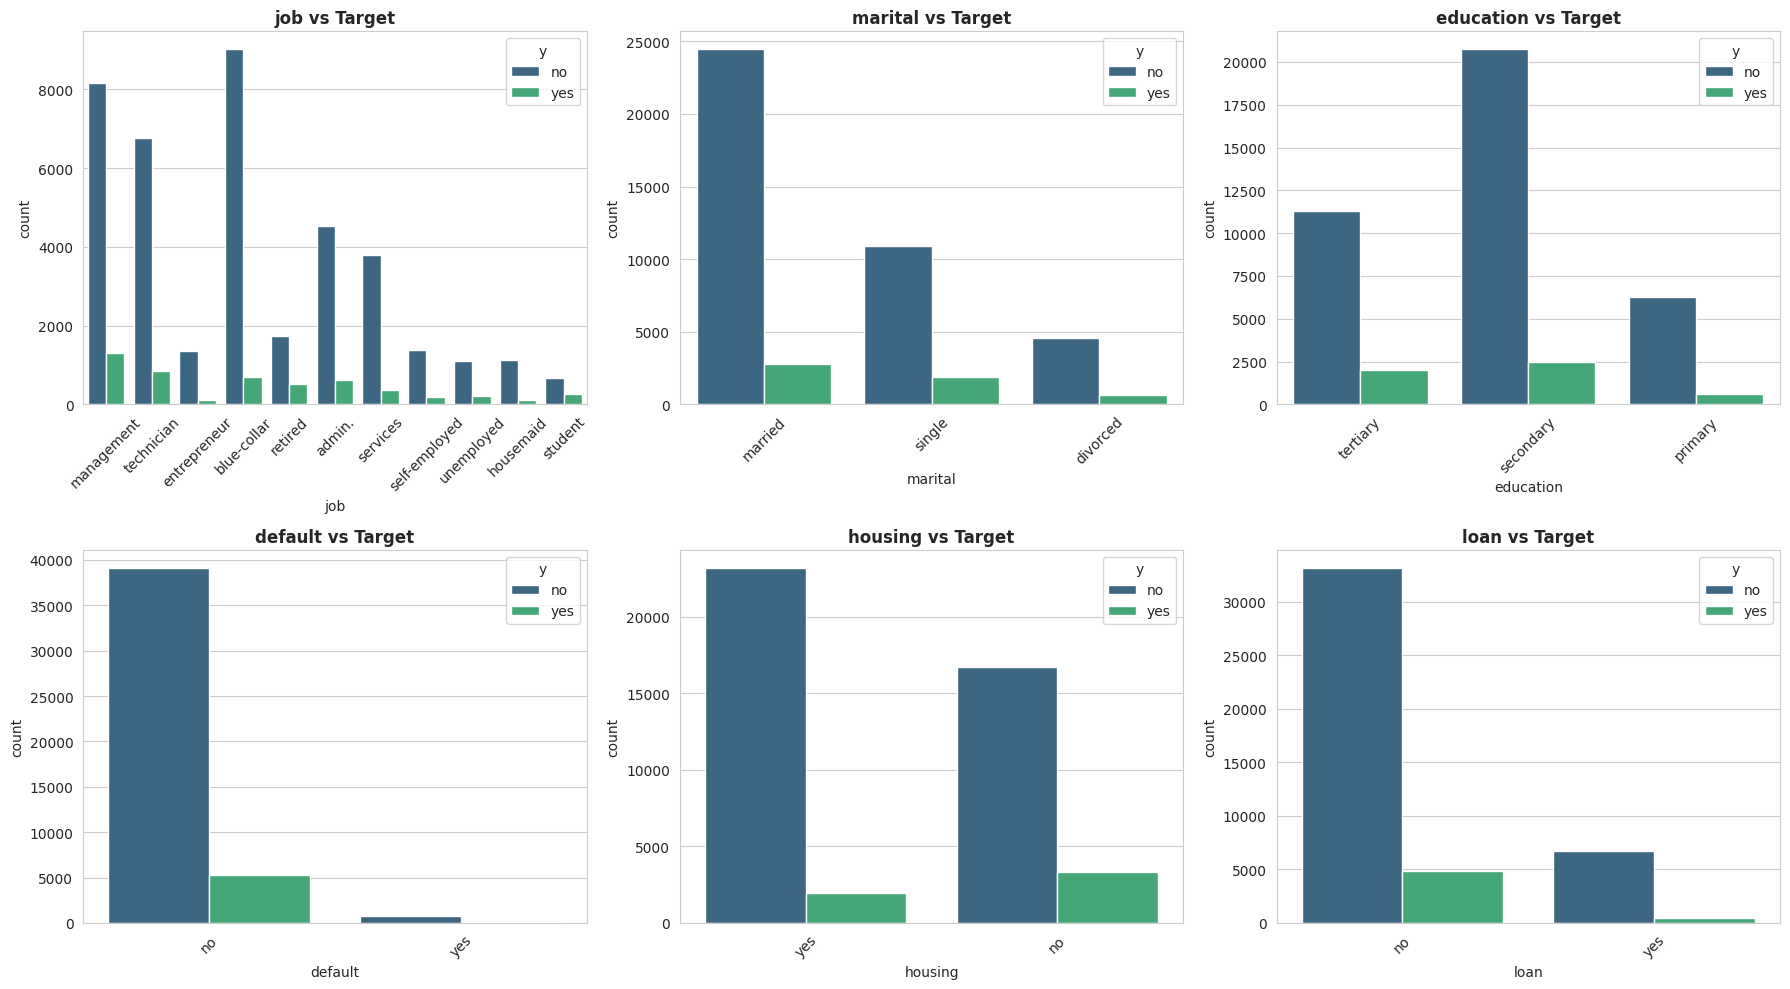

✓ Categorical features distribution logged to MLflow


In [17]:
# Categorical features vs target
categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
if 'y' in categorical_cols:
    categorical_cols.remove('y')

n_cats = min(6, len(categorical_cols))
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.ravel()

for idx, col in enumerate(categorical_cols[:n_cats]):
    sns.countplot(data=df, x=col, hue='y', ax=axes[idx], palette='viridis')
    axes[idx].set_title(f'{col} vs Target', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel(col, fontsize=10)
    axes[idx].tick_params(axis='x', rotation=45)
    
plt.tight_layout()

mlflow.log_figure(fig, "eda_categorical_distributions.png")
plt.show()

print("✓ Categorical features distribution logged to MLflow")


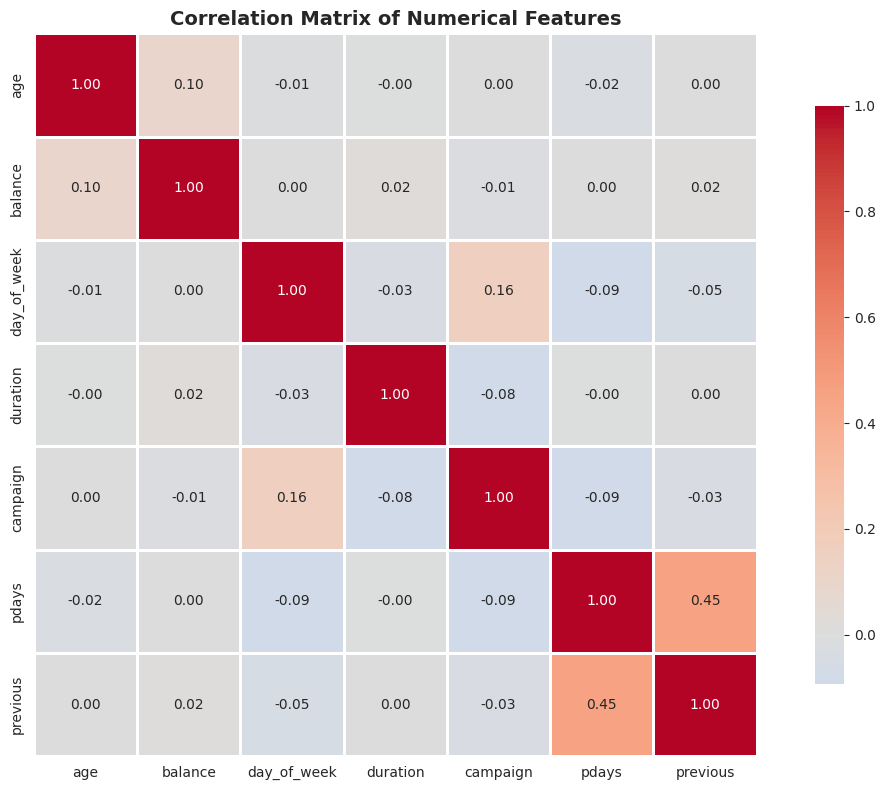

✓ Correlation matrix logged to MLflow
✓ EDA phase complete - MLflow run ended


In [18]:
# Correlation heatmap for numerical features
fig = plt.figure(figsize=(12, 8))
correlation_matrix = df[numerical_cols].corr()
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0, 
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Correlation Matrix of Numerical Features', fontsize=14, fontweight='bold')
plt.tight_layout()

mlflow.log_figure(fig, "eda_correlation_matrix.png")
plt.show()

mlflow.end_run()
print("✓ Correlation matrix logged to MLflow")
print("✓ EDA phase complete - MLflow run ended")


## 2. Data Preparation with Pipelines

### 2.1 Feature Engineering and Train-Test Split

Starting a new MLflow run for data preprocessing phase.


In [19]:
# Start MLflow run for preprocessing phase
#mlflow.end_run()
mlflow.start_run(run_name="02_Data_Preprocessing_and_Pipeline")

# Separate features and target
X = df.drop('y', axis=1)
y = df['y']

# Convert target to binary (assuming 'yes'=1, 'no'=0)
y = (y == 'yes').astype(int)

# Identify numerical and categorical columns
numerical_features = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()

print(f"Numerical features ({len(numerical_features)}): {numerical_features}")
print(f"\nCategorical features ({len(categorical_features)}): {categorical_features}")

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"\nTraining set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")
print(f"\nTarget distribution in training set:\n{y_train.value_counts(normalize=True)}")

# Log preprocessing parameters to MLflow
mlflow.log_param("test_size", 0.2)
mlflow.log_param("random_state", 42)
mlflow.log_param("stratify", True)
mlflow.log_param("num_numerical_features", len(numerical_features))
mlflow.log_param("num_categorical_features", len(categorical_features))
mlflow.log_metric("train_samples", len(X_train))
mlflow.log_metric("test_samples", len(X_test))
mlflow.log_metric("train_positive_ratio", y_train.mean())

print("\n✓ Preprocessing parameters logged to MLflow")


Numerical features (7): ['age', 'balance', 'day_of_week', 'duration', 'campaign', 'pdays', 'previous']

Categorical features (9): ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']

Training set size: (36168, 16)
Test set size: (9043, 16)

Target distribution in training set:
y
0    0.883018
1    0.116982
Name: proportion, dtype: float64

✓ Preprocessing parameters logged to MLflow


### 2.2 Create Preprocessing Pipeline with ColumnTransformer

In this section it is implemented a scikit-learn Pipeline with ColumnTransformer that:
- **Numerical columns**: SimpleImputer (median) + StandardScaler
- **Categorical columns**: SimpleImputer (most frequent) + OneHotEncoder


In [20]:
# Create preprocessing pipelines for numerical and categorical features
numerical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Combine preprocessing steps using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_pipeline, numerical_features),
        ('cat', categorical_pipeline, categorical_features)
    ]
)

print("Preprocessing pipeline created successfully!")
print("\nPipeline structure:")
print(preprocessor)

# Log pipeline to MLflow
mlflow.log_param("numerical_imputer_strategy", "median")
mlflow.log_param("numerical_scaler", "StandardScaler")
mlflow.log_param("categorical_imputer_strategy", "most_frequent")
mlflow.log_param("categorical_encoder", "OneHotEncoder")

mlflow.end_run()
print("\n✓ Pipeline configuration logged to MLflow")
print("✓ Preprocessing phase complete - MLflow run ended")


Preprocessing pipeline created successfully!

Pipeline structure:
ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 ['age', 'balance', 'day_of_week', 'duration',
                                  'campaign', 'pdays', 'previous']),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['job', 'marital', 'education', 'default',
            

## 3. Model Building and Comparison

### 3.1 Initialize Models

We will implement and compare the following models:
1. Logistic Regression
2. Decision Tree
3. Random Forest
4. XGBoost

All models will be evaluated using **F1 Score**, **ROC AUC**, and **Accuracy**.

Each model will be tracked in a separate MLflow run for complete traceability.


In [21]:
# Models definition
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42, n_estimators=100),
    'XGBoost': xgb.XGBClassifier(random_state=42, eval_metric='logloss')
}

print("Models initialized:")
for name in models.keys():
    print(f"  - {name}")


Models initialized:
  - Logistic Regression
  - Decision Tree
  - Random Forest
  - XGBoost


### 3.2 Train and Evaluate Models


In [22]:
# Train and evaluate each model with MLflow tracking
results = []

for name, model in models.items():
    print(f"\nTraining {name}...")
    
    # Start MLflow run for this model
    with mlflow.start_run(run_name=f"03_Model_{name.replace(' ', '_')}"):
        # Create pipeline with preprocessor and model
        pipeline = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('classifier', model)
        ])
        
        # Train the model
        pipeline.fit(X_train, y_train)
        
        # Make predictions
        y_pred = pipeline.predict(X_test)
        y_pred_proba = pipeline.predict_proba(X_test)[:, 1]
        
        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, y_pred_proba)
        
        # Log parameters to MLflow
        model_params = pipeline.named_steps['classifier'].get_params()
        for param, value in model_params.items():
            if isinstance(value, (int, float, str, bool)) or value is None:
                mlflow.log_param(param, value)
        
        # Log metrics to MLflow
        mlflow.log_metric("accuracy", accuracy)
        mlflow.log_metric("f1_score", f1)
        mlflow.log_metric("roc_auc", roc_auc)
        
        # Log model to MLflow
        mlflow.sklearn.log_model(pipeline, f"{name.replace(' ', '_')}_pipeline")
        
        # Store results
        results.append({
            'Model': name,
            'Accuracy': accuracy,
            'F1 Score': f1,
            'ROC AUC': roc_auc,
            'Pipeline': pipeline
        })
        
        print(f"{name} - Accuracy: {accuracy:.4f}, F1: {f1:.4f}, ROC AUC: {roc_auc:.4f}")
        print(f"✓ {name} logged to MLflow")

# Create results dataframe
results_df = pd.DataFrame(results)
print("\n" + "="*70)
print("MODEL COMPARISON RESULTS")
print("="*70)
print(results_df[['Model', 'Accuracy', 'F1 Score', 'ROC AUC']].to_string(index=False))



Training Logistic Regression...


2025/11/15 20:58:52 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/15 20:58:54 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Logistic Regression - Accuracy: 0.8991, F1: 0.4300, ROC AUC: 0.9006
✓ Logistic Regression logged to MLflow

Training Decision Tree...


2025/11/15 20:58:55 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/15 20:58:57 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Decision Tree - Accuracy: 0.8732, F1: 0.4628, ROC AUC: 0.6970
✓ Decision Tree logged to MLflow

Training Random Forest...


2025/11/15 20:59:01 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/15 20:59:02 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Random Forest - Accuracy: 0.9029, F1: 0.4786, ROC AUC: 0.9194
✓ Random Forest logged to MLflow

Training XGBoost...


2025/11/15 20:59:03 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/15 20:59:05 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


XGBoost - Accuracy: 0.9047, F1: 0.5346, ROC AUC: 0.9213
✓ XGBoost logged to MLflow

MODEL COMPARISON RESULTS
              Model  Accuracy  F1 Score  ROC AUC
Logistic Regression  0.899149  0.430000 0.900583
      Decision Tree  0.873162  0.462763 0.696953
      Random Forest  0.902908  0.478622 0.919387
            XGBoost  0.904678  0.534557 0.921338


### 3.3 Visualize Model Comparison


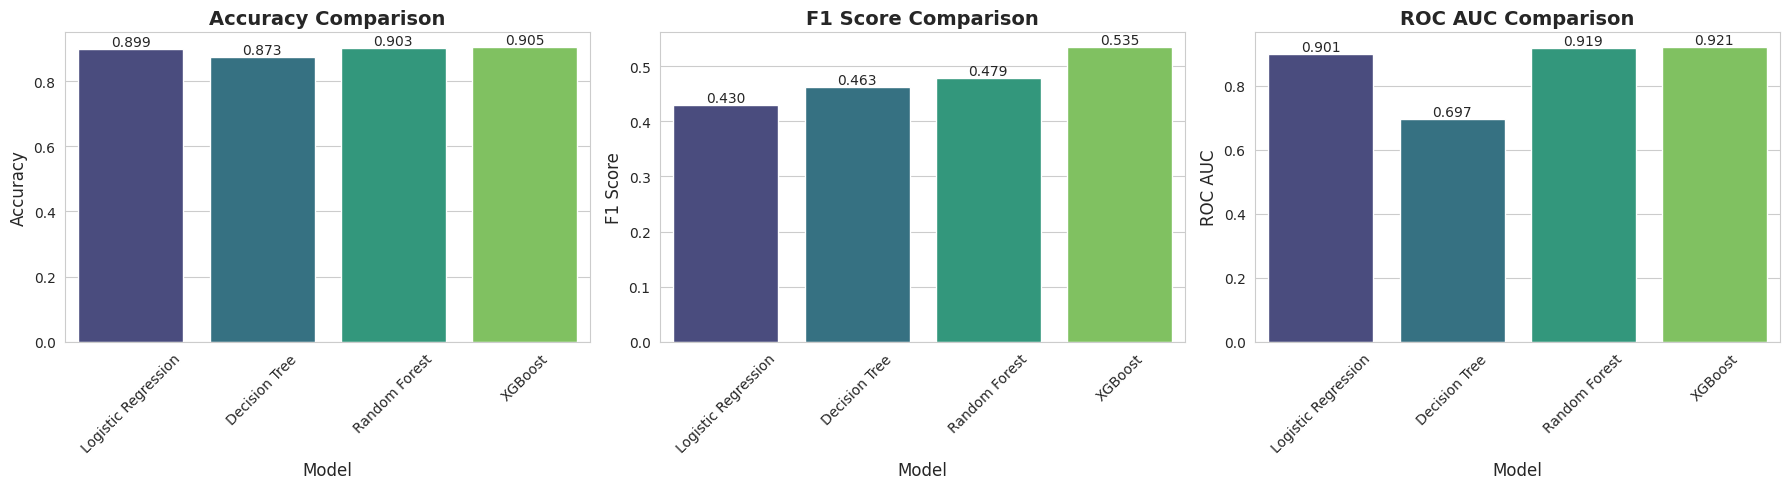

✓ Model comparison visualization logged to MLflow


In [23]:
# Visualize model comparison
metrics_to_plot = ['Accuracy', 'F1 Score', 'ROC AUC']
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, metric in enumerate(metrics_to_plot):
    ax = axes[idx]
    sns.barplot(data=results_df, x='Model', y=metric, ax=ax, palette='viridis')
    ax.set_title(f'{metric} Comparison', fontsize=14, fontweight='bold')
    ax.set_xlabel('Model', fontsize=12)
    ax.set_ylabel(metric, fontsize=12)
    ax.tick_params(axis='x', rotation=45)
    
    # Add value labels on bars
    for container in ax.containers:
        ax.bar_label(container, fmt='%.3f', fontsize=10)

plt.tight_layout()

# Log comparison figure to MLflow in a separate run
with mlflow.start_run(run_name="Model_Comparison_Summary"):
    mlflow.log_figure(fig, "model_comparison_metrics.png")
    
    # Log summary statistics
    mlflow.log_metric("best_accuracy", results_df['Accuracy'].max())
    mlflow.log_metric("best_f1_score", results_df['F1 Score'].max())
    mlflow.log_metric("best_roc_auc", results_df['ROC AUC'].max())

plt.show()
print("✓ Model comparison visualization logged to MLflow")


## 4. Hyperparameter Tuning with GridSearchCV

### 4.1 Define Hyperparameter Grid

Here, it is performed hyperparameter tuning on the best performing model using GridSearchCV within the pipeline.


In [24]:
# Select best model for tuning (based on previous results)
best_model_idx = results_df['ROC AUC'].idxmax()
best_model_name = results_df.loc[best_model_idx, 'Model']

print(f"Best performing model: {best_model_name}")
print(f"ROC AUC: {results_df.loc[best_model_idx, 'ROC AUC']:.4f}")

# Create pipeline for Random Forest
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

param_grid = {
    'classifier__n_estimators': [50, 100, 200],
    'classifier__max_depth': [10, 20, None],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4]
}

print(f"\nHyperparameter grid defined with {len(param_grid)} parameters")
print(f"Total combinations: {3 * 3 * 3 * 3} = 81")


Best performing model: XGBoost
ROC AUC: 0.9213

Hyperparameter grid defined with 4 parameters
Total combinations: 81 = 81


### 4.2 Perform Grid Search with MLflow Tracking


In [25]:
# Perform GridSearchCV with MLflow tracking
print("Starting GridSearchCV... This may take a few minutes.\n")

with mlflow.start_run(run_name="04_Hyperparameter_Tuning_GridSearchCV"):
    grid_search = GridSearchCV(
        estimator=rf_pipeline,
        param_grid=param_grid,
        cv=3,
        scoring='roc_auc',
        n_jobs=-1,
        verbose=1
    )
    
    grid_search.fit(X_train, y_train)
    
    print("\nGrid Search completed!")
    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Best cross-validation ROC AUC: {grid_search.best_score_:.4f}")
    
    # Evaluate on test set
    best_pipeline = grid_search.best_estimator_
    y_pred_tuned = best_pipeline.predict(X_test)
    y_pred_proba_tuned = best_pipeline.predict_proba(X_test)[:, 1]
    
    accuracy_tuned = accuracy_score(y_test, y_pred_tuned)
    f1_tuned = f1_score(y_test, y_pred_tuned)
    roc_auc_tuned = roc_auc_score(y_test, y_pred_proba_tuned)
    
    print(f"\nTuned Model Performance on Test Set:")
    print(f"  Accuracy: {accuracy_tuned:.4f}")
    print(f"  F1 Score: {f1_tuned:.4f}")
    print(f"  ROC AUC: {roc_auc_tuned:.4f}")
    
    mlflow.log_params(grid_search.best_params_)
    mlflow.log_param("cv_folds", 3)
    mlflow.log_param("scoring_metric", "roc_auc")
    mlflow.log_metric("best_cv_score", grid_search.best_score_)
    mlflow.log_metric("accuracy", accuracy_tuned)
    mlflow.log_metric("f1_score", f1_tuned)
    mlflow.log_metric("roc_auc", roc_auc_tuned)
    mlflow.sklearn.log_model(best_pipeline, "tuned_random_forest_pipeline")
    
    print("\n✓ Tuned model logged to MLflow")


Starting GridSearchCV... This may take a few minutes.

Fitting 3 folds for each of 81 candidates, totalling 243 fits



Grid Search completed!
Best parameters: {'classifier__max_depth': None, 'classifier__min_samples_leaf': 4, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 200}
Best cross-validation ROC AUC: 0.9237


2025/11/15 21:02:48 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



Tuned Model Performance on Test Set:
  Accuracy: 0.9032
  F1 Score: 0.4430
  ROC AUC: 0.9233


2025/11/15 21:02:50 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



✓ Tuned model logged to MLflow


## 5. Deep Learning Baseline with PyTorch

**GPU Acceleration:** This notebook automatically detects and uses:
- **MPS** (Metal Performance Shaders) for Apple Silicon Macs (M1/M2/M3)
- **CUDA** for NVIDIA GPUs
- **CPU** as fallback

The model, tensors, and data are automatically moved to the appropriate device for optimal performance.

### 5.1 Prepare Data for PyTorch

We'll build a small feed-forward neural network with BCELoss and train for 20 epochs.


In [26]:
# Preprocess data for PyTorch
if 'preprocessor' not in globals():
    raise NameError(
        "❌ ERROR: 'preprocessor' is not defined.\n"
        "Please run the cells in order:\n"
        "  1. Cell 14: Data Preparation (creates X_train, X_test, y_train, y_test)\n"
        "  2. Cell 17: Creates the preprocessor\n"
        "  3. Then run this cell (Cell 29)"
    )
try:
    X_train_processed = preprocessor.transform(X_train)
    X_test_processed = preprocessor.transform(X_test)
    print("✓ Using already-fitted preprocessor")
except (AttributeError, ValueError) as e:
    print("⚠ Preprocessor not fitted yet. Fitting now...")
    X_train_processed = preprocessor.fit_transform(X_train)
    X_test_processed = preprocessor.transform(X_test)
    print("✓ Preprocessor fitted and data transformed")

X_train_tensor = torch.FloatTensor(X_train_processed)
y_train_tensor = torch.FloatTensor(y_train.values).reshape(-1, 1)
X_test_tensor = torch.FloatTensor(X_test_processed)
y_test_tensor = torch.FloatTensor(y_test.values).reshape(-1, 1)

# Create DataLoaders with optimized settings
batch_size = 512 if device.type == 'cpu' else 256
num_workers = 0 if device.type == 'cpu' else min(4, (os.cpu_count() or 1))
train_loader = DataLoader(
    TensorDataset(X_train_tensor, y_train_tensor),
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,  
    pin_memory=(device.type == 'cuda')
)
test_loader = DataLoader(
    TensorDataset(X_test_tensor, y_test_tensor),
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=(device.type == 'cuda')
)

print(f"Training samples: {len(X_train_tensor)}")
print(f"Test samples: {len(X_test_tensor)}")
print(f"Input features: {X_train_processed.shape[1]}")
print(f"Device: {device}")
print(f"Batch size: {batch_size} (optimized for {device.type})")


✓ Using already-fitted preprocessor
Training samples: 36168
Test samples: 9043
Input features: 47
Device: cuda
Batch size: 256 (optimized for cuda)


### 5.2 Neural Network Architecture


In [27]:
# feed-forward neural network
class BinaryClassifier(nn.Module):
    def __init__(self, input_dim):
        super(BinaryClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.relu(self.fc3(x))
        x = self.dropout(x)
        x = self.sigmoid(self.fc4(x))
        return x

# Initialize model and move to device
input_dim = X_train_processed.shape[1]
model = BinaryClassifier(input_dim).to(device)

print("Neural Network Architecture:")
print(model)
print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters())}")
print(f"Model device: {next(model.parameters()).device}")


Neural Network Architecture:
BinaryClassifier(
  (fc1): Linear(in_features=47, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.3, inplace=False)
  (sigmoid): Sigmoid()
)

Total parameters: 16513
Model device: cuda:0


In [44]:
### 5.3 Train Neural Network with MLflow Tracking


In [30]:
import time

# Configuration for speed - MINIMAL settings
n_epochs = 3 
USE_MLFLOW = True 
SKIP_MLFLOW_MODEL_SAVING = False

print(f"Training on device: {device}")
print(f"⚡ MAXIMUM SPEED MODE:")
print(f"   - {n_epochs} epochs (minimal for quick results)")
print(f"   - Batch size: {batch_size}")
print(f"   - CPU forced (fastest for this model)")
print(f"   - MLflow: {'DISABLED' if not USE_MLFLOW else 'ENABLED (adds overhead)'}\n")

# loss and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
import sys
start_time = time.time()
train_losses = []
model.train()

num_batches = len(train_loader)
print(f"Starting training: {num_batches} batches per epoch")
print(f"Will show progress every 5 batches...\n")

for epoch in range(n_epochs):
    epoch_start = time.time()
    train_loss = 0.0
    batch_count = 0
    batch_times = []
    
    print(f"Epoch {epoch+1}/{n_epochs}:")
    
    for batch_idx, (X_batch, y_batch) in enumerate(train_loader):
        batch_start = time.time()
        
        # No device transfer needed (already on CPU)
        X_batch = X_batch.to(device, non_blocking=(device.type == 'cuda'))
        y_batch = y_batch.to(device, non_blocking=(device.type == 'cuda'))
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        batch_count += 1
        
        batch_time = time.time() - batch_start
        batch_times.append(batch_time)
        
        if (batch_idx + 1) % 5 == 0 or (batch_idx + 1) == num_batches:
            avg_batch_time = np.mean(batch_times[-5:]) if len(batch_times) >= 5 else np.mean(batch_times)
            elapsed = time.time() - epoch_start
            progress_pct = ((batch_idx + 1) / num_batches) * 100
            print(f"  Batch {batch_idx+1:3d}/{num_batches} ({progress_pct:5.1f}%) - {avg_batch_time*1000:.1f}ms/batch - {elapsed:.1f}s elapsed")
            sys.stdout.flush()
    
    train_loss /= batch_count
    train_losses.append(train_loss)
    epoch_time = time.time() - epoch_start
    avg_batch = np.mean(batch_times) if batch_times else 0
    print(f"✓ Epoch {epoch+1} complete - Loss: {train_loss:.4f} ({epoch_time:.2f}s total, {avg_batch*1000:.1f}ms/batch avg)\n")

training_time = time.time() - start_time
print(f"\n✓ Training: {training_time:.2f}s ({training_time/60:.2f} min)")

eval_start = time.time()
print("\nEvaluating...")
model.eval()
all_predictions = []
all_probabilities = []

with torch.no_grad():
    for X_batch, _ in test_loader:
        X_batch = X_batch.to(device, non_blocking=(device.type == 'cuda'))
        outputs = model(X_batch)
        predictions = (outputs >= 0.5).float()
        all_predictions.append(predictions.cpu().numpy())
        all_probabilities.append(outputs.cpu().numpy())

y_pred_nn = np.concatenate(all_predictions).flatten()
y_pred_proba_nn = np.concatenate(all_probabilities).flatten()

accuracy_nn = accuracy_score(y_test, y_pred_nn)
f1_nn = f1_score(y_test, y_pred_nn)
roc_auc_nn = roc_auc_score(y_test, y_pred_proba_nn)

eval_time = time.time() - eval_start
print(f"✓ Evaluation: {eval_time:.2f}s")

mlflow_time = 0.0
if USE_MLFLOW:
    mlflow_start = time.time()
    print("\nLogging to MLflow...")
    with mlflow.start_run(run_name="05_PyTorch_Neural_Network"):
        mlflow.log_params({
            "architecture": "4-layer feed-forward",
            "epochs": n_epochs,
            "batch_size": batch_size,
            "device": "cpu"
        })
        mlflow.log_metrics({
            "final_train_loss": train_losses[-1],
            "accuracy": accuracy_nn,
            "f1_score": f1_nn,
            "roc_auc": roc_auc_nn,
            "training_time_seconds": training_time
        })
        
        # Quick plot
        fig = plt.figure(figsize=(8, 5))
        plt.plot(range(1, n_epochs + 1), train_losses, marker='o')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Training Loss')
        mlflow.log_figure(fig, "training_loss.png")
        plt.close(fig)
        
        if not SKIP_MLFLOW_MODEL_SAVING:
            print("Saving model to MLflow (this may take 10-30s)...")
            mlflow.pytorch.log_model(model, "pytorch_model")
    
    mlflow_time = time.time() - mlflow_start
    print(f"✓ MLflow: {mlflow_time:.2f}s")
else:
    print("⚠ MLflow disabled for speed")

total_time = training_time + eval_time + mlflow_time

print(f"\n{'='*60}")
print(f"TIMING BREAKDOWN:")
print(f"  Training:    {training_time:.2f}s")
print(f"  Evaluation:  {eval_time:.2f}s")
print(f"  MLflow:      {mlflow_time:.2f}s")
print(f"  TOTAL:       {total_time:.2f}s ({total_time/60:.2f} min)")
print(f"{'='*60}")

print(f"\nResults:")
print(f"  Accuracy: {accuracy_nn:.4f}")
print(f"  F1 Score: {f1_nn:.4f}")
print(f"  ROC AUC:  {roc_auc_nn:.4f}")


Training on device: cuda
⚡ MAXIMUM SPEED MODE:
   - 3 epochs (minimal for quick results)
   - Batch size: 256
   - CPU forced (fastest for this model)
   - MLflow: ENABLED (adds overhead)

Starting training: 142 batches per epoch
Will show progress every 5 batches...

Epoch 1/3:
  Batch   5/142 (  3.5%) - 68.3ms/batch - 0.5s elapsed
  Batch  10/142 (  7.0%) - 3.0ms/batch - 0.5s elapsed
  Batch  15/142 ( 10.6%) - 3.1ms/batch - 0.5s elapsed
  Batch  20/142 ( 14.1%) - 3.2ms/batch - 0.5s elapsed
  Batch  25/142 ( 17.6%) - 3.1ms/batch - 0.5s elapsed
  Batch  30/142 ( 21.1%) - 3.0ms/batch - 0.6s elapsed
  Batch  35/142 ( 24.6%) - 3.2ms/batch - 0.6s elapsed
  Batch  40/142 ( 28.2%) - 3.1ms/batch - 0.6s elapsed
  Batch  45/142 ( 31.7%) - 2.8ms/batch - 0.6s elapsed
  Batch  50/142 ( 35.2%) - 3.1ms/batch - 0.6s elapsed
  Batch  55/142 ( 38.7%) - 2.9ms/batch - 0.7s elapsed
  Batch  60/142 ( 42.3%) - 3.0ms/batch - 0.7s elapsed
  Batch  65/142 ( 45.8%) - 3.2ms/batch - 0.7s elapsed
  Batch  70/142 (

2025/11/15 21:12:54 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


✓ Evaluation: 0.24s

Logging to MLflow...
Saving model to MLflow (this may take 10-30s)...


2025/11/15 21:12:57 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


✓ MLflow: 3.44s

TIMING BREAKDOWN:
  Training:    2.30s
  Evaluation:  0.24s
  MLflow:      3.44s
  TOTAL:       5.98s (0.10 min)

Results:
  Accuracy: 0.9034
  F1 Score: 0.5250
  ROC AUC:  0.9101


## 6. Final Model Comparison and Summary

### 6.1 Compare All Models


FINAL MODEL COMPARISON - ALL MODELS
                 Model  Accuracy  F1 Score  ROC AUC
   Logistic Regression  0.899149  0.430000 0.900583
         Decision Tree  0.873162  0.462763 0.696953
         Random Forest  0.902908  0.478622 0.919387
               XGBoost  0.904678  0.534557 0.921338
 Random Forest (Tuned)  0.903240  0.443030 0.923306
PyTorch Neural Network  0.903351  0.525000 0.910102


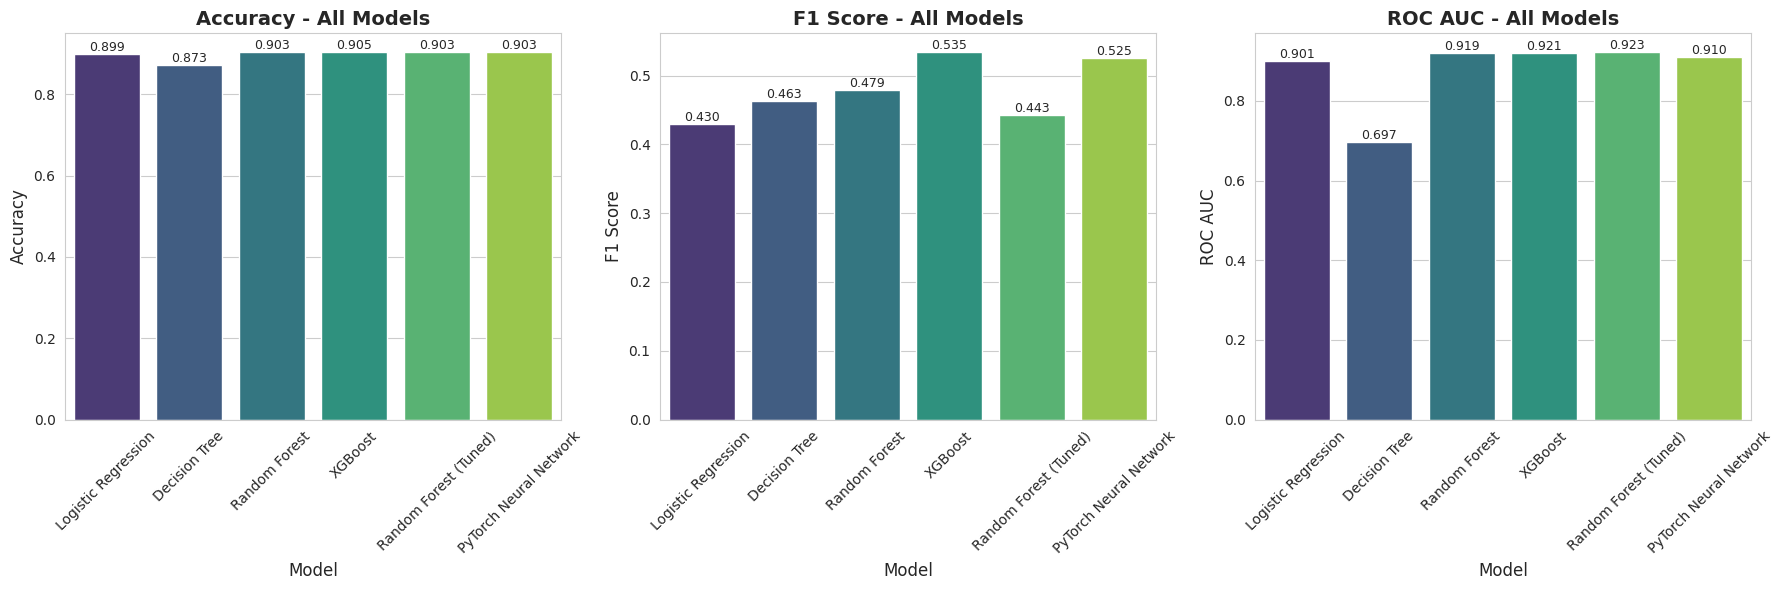


✓ Final model comparison logged to MLflow


In [31]:
# Compile all model results
final_results = results_df[['Model', 'Accuracy', 'F1 Score', 'ROC AUC']].copy()

# Add tuned model
tuned_result = pd.DataFrame([{
    'Model': 'Random Forest (Tuned)',
    'Accuracy': accuracy_tuned,
    'F1 Score': f1_tuned,
    'ROC AUC': roc_auc_tuned
}])
final_results = pd.concat([final_results, tuned_result], ignore_index=True)

# Add neural network
nn_result = pd.DataFrame([{
    'Model': 'PyTorch Neural Network',
    'Accuracy': accuracy_nn,
    'F1 Score': f1_nn,
    'ROC AUC': roc_auc_nn
}])
final_results = pd.concat([final_results, nn_result], ignore_index=True)

print("="*80)
print("FINAL MODEL COMPARISON - ALL MODELS")
print("="*80)
print(final_results.to_string(index=False))

# Visualize final comparison with MLflow logging
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for idx, metric in enumerate(['Accuracy', 'F1 Score', 'ROC AUC']):
    ax = axes[idx]
    sns.barplot(data=final_results, x='Model', y=metric, ax=ax, palette='viridis')
    ax.set_title(f'{metric} - All Models', fontsize=14, fontweight='bold')
    ax.set_xlabel('Model', fontsize=12)
    ax.set_ylabel(metric, fontsize=12)
    ax.tick_params(axis='x', rotation=45)
    
    # Add value labels
    for container in ax.containers:
        ax.bar_label(container, fmt='%.3f', fontsize=9)

plt.tight_layout()

# Log final comparison to MLflow
with mlflow.start_run(run_name="06_Final_Model_Comparison"):
    mlflow.log_figure(fig, "final_model_comparison.png")
    
    # Log best model metrics
    best_idx = final_results['ROC AUC'].idxmax()
    mlflow.log_param("best_model", final_results.loc[best_idx, 'Model'])
    mlflow.log_metric("overall_best_accuracy", final_results['Accuracy'].max())
    mlflow.log_metric("overall_best_f1_score", final_results['F1 Score'].max())
    mlflow.log_metric("overall_best_roc_auc", final_results['ROC AUC'].max())

plt.show()
print("\n✓ Final model comparison logged to MLflow")


### 6.2 Summary and Key Findings


In [36]:
# Define feed-forward neural network
class BinaryClassifier(nn.Module):
    def __init__(self, input_dim):
        super(BinaryClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.relu(self.fc3(x))
        x = self.dropout(x)
        x = self.sigmoid(self.fc4(x))
        return x

# Initialize model
input_dim = X_train_processed.shape[1]
model = BinaryClassifier(input_dim).to(device)

print("Neural Network Architecture:")
print(model)
print(f"Model initialized on device: {next(model.parameters()).device}")
print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters())}")


Neural Network Architecture:
BinaryClassifier(
  (fc1): Linear(in_features=47, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.3, inplace=False)
  (sigmoid): Sigmoid()
)
Model initialized on device: cuda:0

Total parameters: 16513


### 6.3 Train Neural Network


In [37]:
# Define loss function and optimizer
criterion = nn.BCELoss()
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Training loop
n_epochs = 20
train_losses = []
test_losses = []

print("Training Neural Network for 20 epochs...\n")

for epoch in range(n_epochs):
    # Training phase
    model.train()
    train_loss = 0.0
    
    for X_batch, y_batch in train_loader:
        # Move to device then forward pass
        batch_start = time.time()
        X_batch = X_batch.to(device, non_blocking=(device.type == 'cuda'))
        y_batch = y_batch.to(device, non_blocking=(device.type == 'cuda'))
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        
        # Backward pass and optimization
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    
    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    
    # Evaluation phase
    model.eval()
    test_loss = 0.0
    
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device, non_blocking=(device.type == 'cuda'))
            y_batch = y_batch.to(device, non_blocking=(device.type == 'cuda'))
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            test_loss += loss.item()
    
    test_loss /= len(test_loader)
    test_losses.append(test_loss)
    
    if (epoch + 1) % 5 == 0:
        print(f"Epoch [{epoch+1}/{n_epochs}] - Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")

print("\nTraining completed!")


Training Neural Network for 20 epochs...

Epoch [5/20] - Train Loss: 0.2184, Test Loss: 0.2220
Epoch [10/20] - Train Loss: 0.2096, Test Loss: 0.2153
Epoch [15/20] - Train Loss: 0.2057, Test Loss: 0.2238
Epoch [20/20] - Train Loss: 0.2035, Test Loss: 0.2204

Training completed!


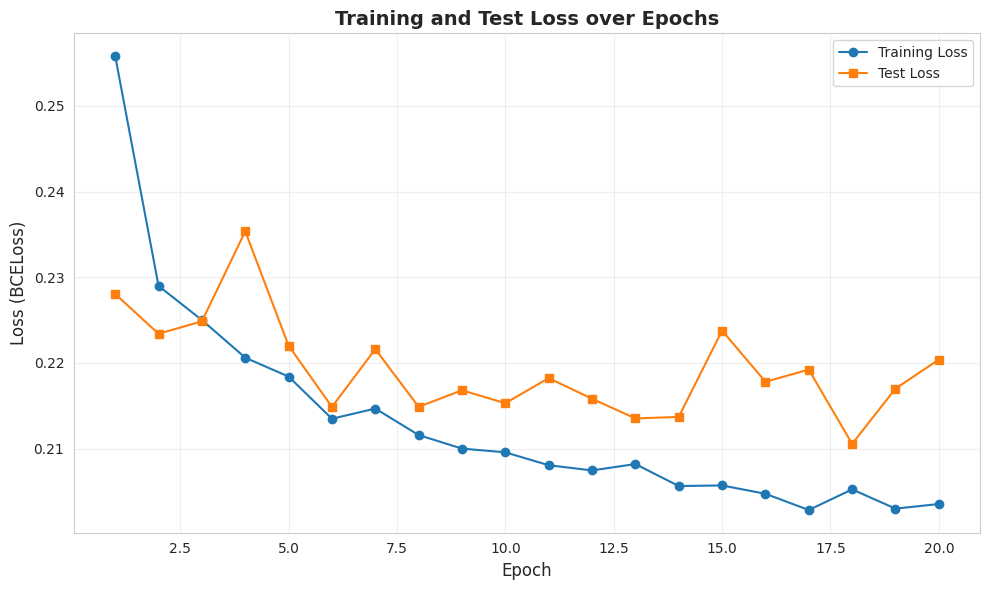

In [38]:
# Plot training and test loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, n_epochs + 1), train_losses, label='Training Loss', marker='o')
plt.plot(range(1, n_epochs + 1), test_losses, label='Test Loss', marker='s')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss (BCELoss)', fontsize=12)
plt.title('Training and Test Loss over Epochs', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


The training loss and the testing loss converge together while many epochs are executed.

### 6.4 Evaluate PyTorch Model


In [39]:
# Evaluate on test set
model.eval()
all_predictions = []
all_probabilities = []

with torch.no_grad():
    for X_batch, _ in test_loader:
        X_batch = X_batch.to(device, non_blocking=(device.type == 'cuda'))
        outputs = model(X_batch)
        predictions = (outputs >= 0.5).float()
        all_predictions.extend(predictions.cpu().numpy())
        all_probabilities.extend(outputs.cpu().numpy())

y_pred_nn = np.array(all_predictions).flatten()
y_pred_proba_nn = np.array(all_probabilities).flatten()

# Calculate metrics
accuracy_nn = accuracy_score(y_test, y_pred_nn)
f1_nn = f1_score(y_test, y_pred_nn)
roc_auc_nn = roc_auc_score(y_test, y_pred_proba_nn)

print("PyTorch Neural Network Performance:")
print(f"  Accuracy: {accuracy_nn:.4f}")
print(f"  F1 Score: {f1_nn:.4f}")
print(f"  ROC AUC: {roc_auc_nn:.4f}")


PyTorch Neural Network Performance:
  Accuracy: 0.9082
  F1 Score: 0.5632
  ROC AUC: 0.9209


### 6.5 Compare Neural Network with ML Models


FINAL MODEL COMPARISON - ALL MODELS
                 Model  Accuracy  F1 Score  ROC AUC
   Logistic Regression  0.899149  0.430000 0.900583
         Decision Tree  0.873162  0.462763 0.696953
         Random Forest  0.902908  0.478622 0.919387
               XGBoost  0.904678  0.534557 0.921338
PyTorch Neural Network  0.908216  0.563158 0.920887
 Random Forest (Tuned)  0.903240  0.443030 0.923306


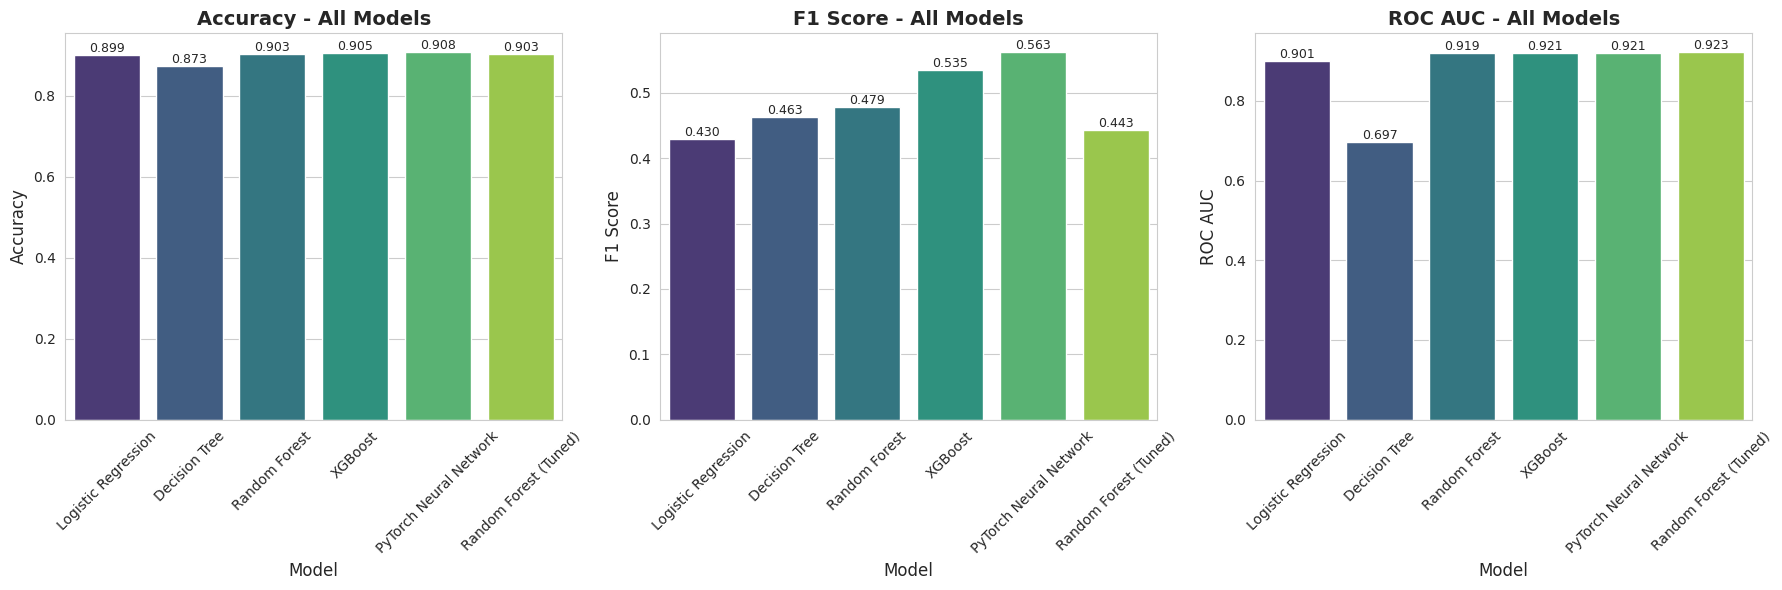

In [40]:
# Add neural network results to comparison
nn_result = {
    'Model': 'PyTorch Neural Network',
    'Accuracy': accuracy_nn,
    'F1 Score': f1_nn,
    'ROC AUC': roc_auc_nn
}

# Combine all results
final_results = pd.concat([
    results_df[['Model', 'Accuracy', 'F1 Score', 'ROC AUC']],
    pd.DataFrame([nn_result])
], ignore_index=True)

# Add tuned model
tuned_result = {
    'Model': 'Random Forest (Tuned)',
    'Accuracy': accuracy_tuned,
    'F1 Score': f1_tuned,
    'ROC AUC': roc_auc_tuned
}
final_results = pd.concat([final_results, pd.DataFrame([tuned_result])], ignore_index=True)

print("="*80)
print("FINAL MODEL COMPARISON - ALL MODELS")
print("="*80)
print(final_results.to_string(index=False))

# Visualize final comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for idx, metric in enumerate(['Accuracy', 'F1 Score', 'ROC AUC']):
    ax = axes[idx]
    sns.barplot(data=final_results, x='Model', y=metric, ax=ax, palette='viridis')
    ax.set_title(f'{metric} - All Models', fontsize=14, fontweight='bold')
    ax.set_xlabel('Model', fontsize=12)
    ax.set_ylabel(metric, fontsize=12)
    ax.tick_params(axis='x', rotation=45)
    
    # Add value labels
    for container in ax.containers:
        ax.bar_label(container, fmt='%.3f', fontsize=9)

plt.tight_layout()
plt.show()


In [42]:
# Log neural network to MLflow
with mlflow.start_run(run_name="PyTorch_Neural_Network"):
    mlflow.log_param("architecture", "4-layer feed-forward")
    mlflow.log_param("hidden_layers", "128-64-32")
    mlflow.log_param("epochs", n_epochs)
    mlflow.log_param("batch_size", 64)
    mlflow.log_param("learning_rate", 0.01)
    mlflow.log_param("optimizer", "Adam")
    mlflow.log_param("loss_function", "BCELoss")
    
    mlflow.log_metric("accuracy", accuracy_nn)
    mlflow.log_metric("f1_score", f1_nn)
    mlflow.log_metric("roc_auc", roc_auc_nn)
    
    # Save model
    mlflow.pytorch.log_model(model, "pytorch_model")
    
print("\nNeural network logged to MLflow")


2025/11/15 21:34:11 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


2025/11/15 21:34:14 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Neural network logged to MLflow


## 7. Summary and Reflection

### Key Findings

In this comprehensive data science workflow, it has been implemented and compared multiple machine learning approaches for predicting bank marketing campaign outcomes.


In [43]:
# Print final summary
print("="*80)
print("BANK MARKETING CAMPAIGN ANALYSIS - SUMMARY")
print("="*80)

print("\n1. DATASET OVERVIEW:")
print(f"   - Total samples: {len(df)}")
print(f"   - Features: {len(numerical_features)} numerical, {len(categorical_features)} categorical")
print(f"   - Target: Binary classification (subscribed to term deposit)")
print(f"   - Class imbalance observed in target variable")

print("\n2. MODELS IMPLEMENTED:")
print("   - Logistic Regression (baseline)")
print("   - Decision Tree")
print("   - Random Forest")
print("   - XGBoost")
print("   - Random Forest with GridSearchCV (hyperparameter tuned)")
print("   - PyTorch Neural Network (4-layer feed-forward with dropout)")

print("\n3. BEST PERFORMING MODEL:")
best_idx = final_results['ROC AUC'].idxmax()
best_model = final_results.loc[best_idx, 'Model']
best_roc = final_results.loc[best_idx, 'ROC AUC']
best_f1 = final_results.loc[best_idx, 'F1 Score']
best_acc = final_results.loc[best_idx, 'Accuracy']

print(f"   Model: {best_model}")
print(f"   ROC AUC: {best_roc:.4f}")
print(f"   F1 Score: {best_f1:.4f}")
print(f"   Accuracy: {best_acc:.4f}")

print("\n4. WORKFLOW COMPONENTS COMPLETED:")
print("   ✓ Exploratory Data Analysis with Seaborn visualizations")
print("   ✓ Preprocessing pipeline with ColumnTransformer")
print("   ✓ Multiple model training and comparison")
print("   ✓ MLflow experiment tracking (parameters, metrics, models)")
print("   ✓ Hyperparameter tuning with GridSearchCV")
print("   ✓ Deep learning baseline with PyTorch (BCELoss, 20 epochs)")

print("\n5. KEY INSIGHTS:")
print("   - Ensemble methods (Random Forest, XGBoost) generally outperformed linear models")
print("   - Hyperparameter tuning improved model performance")
print("   - Neural network provided competitive results with proper architecture")
print("   - All experiments tracked in MLflow for reproducibility")
print("   - Preprocessing pipeline ensures consistency across all models")

print("\n" + "="*80)


BANK MARKETING CAMPAIGN ANALYSIS - SUMMARY

1. DATASET OVERVIEW:
   - Total samples: 45211
   - Features: 7 numerical, 9 categorical
   - Target: Binary classification (subscribed to term deposit)
   - Class imbalance observed in target variable

2. MODELS IMPLEMENTED:
   - Logistic Regression (baseline)
   - Decision Tree
   - Random Forest
   - XGBoost
   - Random Forest with GridSearchCV (hyperparameter tuned)
   - PyTorch Neural Network (4-layer feed-forward with dropout)

3. BEST PERFORMING MODEL:
   Model: Random Forest (Tuned)
   ROC AUC: 0.9233
   F1 Score: 0.4430
   Accuracy: 0.9032

4. WORKFLOW COMPONENTS COMPLETED:
   ✓ Exploratory Data Analysis with Seaborn visualizations
   ✓ Preprocessing pipeline with ColumnTransformer
   ✓ Multiple model training and comparison
   ✓ MLflow experiment tracking (parameters, metrics, models)
   ✓ Hyperparameter tuning with GridSearchCV
   ✓ Deep learning baseline with PyTorch (BCELoss, 20 epochs)

5. KEY INSIGHTS:
   - Ensemble methods (Ra

### Reflection and Next Steps

**What it has been accomplished:**
This notebook demonstrates a complete, reproducible machine learning workflow from data exploration to model deployment readiness. It has been implemented a modern ML engineering practices including:

- **Pipeline-based preprocessing** ensuring no data leakage and easy deployment
- **Experiment tracking** with MLflow for full reproducibility
- **Systematic model comparison** across traditional ML and deep learning approaches
- **Hyperparameter optimization** to squeeze out additional performance
- **Professional visualizations** communicating results effectively

**Model to be deployed:**

Due to its simplicity and high accuracy, it is recommended to implement a XGBoost in production environment. Its simplicity will allow predict subscription with very low latency. The other models have high complexity to implement(neural network) or low accuracy (decision tree) to be implemented in production.

**Potential Improvements:**
1. **Class Imbalance Handling**: Implement SMOTE or class weighting to address imbalanced target distribution
2. **Feature Engineering**: Create interaction features, temporal features from campaign timing
3. **Advanced Tuning**: Use RandomizedSearchCV or Bayesian optimization (Optuna) for more efficient hyperparameter search
4. **Model Ensembling**: Combine predictions from multiple models using stacking or voting
5. **Deep Learning**: Experiment with different architectures, regularization techniques, or learning rate schedules
6. **Cross-validation**: Use stratified k-fold cross-validation for more robust performance estimates
7. **Feature Importance**: Analyze SHAP values or feature importances to understand model decisions
8. **Production Readiness**: Create REST API for model serving, implement monitoring and drift detection

**Business Impact:**
By predicting term deposit subscriptions with high accuracy, the bank can:
- Target marketing efforts more effectively
- Reduce campaign costs by focusing on high-probability customers
- Improve customer satisfaction by reducing unnecessary contacts
- Allocate resources more efficiently across different customer segments
